# 移除低方差特征

### VarianceThreshold 是特征选择的一个简单基本方法，它会移除所有那些方差不满足一些阈值的特征。默认情况下，它将会移除所有的零方差特征，即那些在所有的样本上的取值均不变的特征。

In [1]:
# ============去除方差小于阈值的特征============  
from sklearn.feature_selection import VarianceThreshold  #移除低方差特征  
from sklearn.datasets import load_iris  # 引入花卉数据集  
iris = load_iris()  
X= iris.data  
print(X.shape)  
print(X.var(axis=0))  

sel = VarianceThreshold(threshold=0.2)  
X_transformed=sel.fit_transform(X)  
print('去除低方差特征：\n',X_transformed.shape)  

(150, 4)
[0.68112222 0.18871289 3.09550267 0.57713289]
去除低方差特征：
 (150, 3)


---
# 单变量特征选择

### 单变量的特征选择是通过基于单变量的统计测试来选择最好的特征。它可以当做是评估器的预处理步骤。Scikit-learn 将特征选择的内容作为实现了 transform 方法的对象：

+ SelectKBest 移除那些除了评分最高的 K 个特征之外的所有特征
+ SelectPercentile 移除除了用户指定的最高得分百分比之外的所有特征
+ 对每个特征应用常见的单变量统计测试: 假阳性率（false positive rate） + SelectFpr, 伪发现率（false discovery rate） SelectFdr , 或者族系误差（family wise error） SelectFwe 。
+ GenericUnivariateSelect 允许使用可配置方法来进行单变量特征选择。它允许超参数搜索评估器来选择最好的单变量特征。

In [2]:
# ============排序选择优秀特征============  
from sklearn.datasets import load_iris  
from sklearn.feature_selection import SelectKBest  
from sklearn.feature_selection import chi2  # 引入卡方检验统计量  
# 对于回归: f_regression , mutual_info_regression  
# 对于分类: chi2 , f_classif , mutual_info_classif  
iris = load_iris()  
X, y = iris.data, iris.target  
print('源样本维度：',X.shape)  

X_new = SelectKBest(chi2, k=2).fit_transform(X, y)  
print('新样本维度：',X_new.shape)  

源样本维度： (150, 4)
新样本维度： (150, 2)


---
# 递归式特征消除

### 给定一个外部的估计器，可以对特征赋予一定的权重（比如，线性模型的相关系数），recursive feature elimination ( RFE ) 通过考虑越来越小的特征集合来递归的选择特征。 首先，评估器在初始的特征集合上面训练并且每一个特征的重要程度是通过一个 coef_ 属性 或者 feature_importances_ 属性来获得。 然后，从当前的特征集合中移除最不重要的特征。在特征集合上不断的重复递归这个步骤，直到最终达到所需要的特征数量为止。 RFECV 在一个交叉验证的循环中执行 RFE 来找到最优的特征数量。

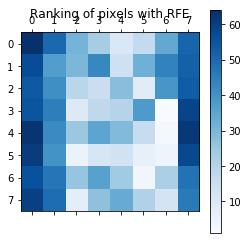

In [4]:
# ============递归式特征消除============  
# 这里递归的移除最不重要的像素点来对每个像素点（特征）进行排序  
from sklearn.svm import SVC  
from sklearn.datasets import load_digits  
from sklearn.feature_selection import RFE  
import matplotlib.pyplot as plt  

digits = load_digits()  # 加载手写体数据集  
X = digits.images.reshape((len(digits.images), -1))  
y = digits.target  

# 创建ref对象和每个像素点的重要度排名  
svc = SVC(kernel="linear", C=1)  
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)  
rfe.fit(X, y)  
ranking = rfe.ranking_.reshape(digits.images[0].shape)  

# 绘制像素点排名  
plt.matshow(ranking, cmap=plt.cm.Blues)  
plt.colorbar()  
plt.title("Ranking of pixels with RFE")  
plt.show()  

---
# 使用 SelectFromModel 选取特征

### SelectFromModel 是一个 meta-transformer（元转换器） ，它可以用来处理任何带有$coef_$ 或者 feature_importances_ 属性的训练之后的评估器。 如果相关的coef_ 或者 featureimportances 属性值低于预先设置的阈值，这些特征将会被认为不重要并且移除掉。除了指定数值上的阈值之外，还可以通过给定字符串参数来使用内置的启发式方法找到一个合适的阈值。可以使用的启发式方法有 mean 、 median 以及使用浮点数乘以这些（例如，0.1*mean ）。

/home/sizheng/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


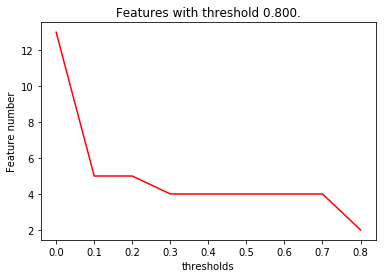

In [5]:
# ============使用 SelectFromModel 选取特征============  

import matplotlib.pyplot as plt  
from sklearn.datasets import load_boston  
from sklearn.feature_selection import SelectFromModel  
from sklearn.linear_model import LassoCV  
boston = load_boston()  # 加载波士顿房价回归数据  
X, y = boston['data'], boston['target']  # 取特征数据和输出数据  
n_features =[13]  # 记录循环中的特征个数，最开始数据集是有13个特征的  
thresholds=[0]  # 记录门限值，最开始是没有门限值的  

clf = LassoCV()  # 使用Lasso回归  

# 设置最小门限为0.25。coef_ 或者 featureimportances 属性值低于门限的都会被去除调  
sfm = SelectFromModel(clf, threshold=0.1)  
sfm.fit(X, y)  # 训练模型。找出模型回归系数。  
X_transform = sfm.transform(X) # 根据回归系数、门限，变换数据集。  
n_feature =X_transform.shape[1]  # 获取训练以后的特征数目  
n_features.append(n_feature)  
thresholds.append(0.1)  
while n_feature > 2:  # 如果特征数大于2，则从新转换，找最好的两个特征  
    sfm.threshold += 0.1  # 逐渐增加门限，进一步减少特征数目  
    X_transform = sfm.transform(X) # 变换数据集  
    n_feature = X_transform.shape[1]  
    n_features.append(n_feature)  # 记录训练以后的特征数目  
    thresholds.append(sfm.threshold)  # 记录门限值  

plt.title("Features with threshold %0.3f." % sfm.threshold)  
plt.plot(thresholds, n_features, 'r')  
plt.xlabel("thresholds")  
plt.ylabel("Feature number")  
plt.show()  

---
# 基于 L1 的特征选取

### Linear models 使用 L1 正则化的线性模型会得到稀疏解：他们的许多系数为 0。 当目标是降低使用另一个分类器的数据集的维度， 它们可以与 feature_selection.SelectFromModel 一起使用来选择非零系数。特别的，可以用于此目的的稀疏评估器有用于回归的 linear_model.Lasso , 以及用于分类的 linear_model.LogisticRegression 和 svm.LinearSVC。
  
  
### 在 SVM 和逻辑回归中，参数 C 是用来控制稀疏性的：小的 C 会导致少的特征被选择。使用 Lasso，alpha 的值越大，越少的特征会被选择。

In [ ]:
# ============基于 L1 的特征选取============  
from sklearn.svm import LinearSVC  
from sklearn.datasets import load_iris  
from sklearn.feature_selection import SelectFromModel  
iris = load_iris()  
X, y = iris.data, iris.target  
print('原数据集维度：',X.shape)  
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)  
model = SelectFromModel(lsvc, prefit=True)  
X_new = model.transform(X)  
print('新数据集维度：',X_new.shape)  

---
# 基于 Tree（树）的特征选取

### 基于树的 estimators （查阅 sklearn.tree 模块和树的森林 在 sklearn.ensemble 模块） 可以用来计算特征的重要性，然后可以消除不相关的特征（当与 sklearn.feature_selection.SelectFromModel 等元转换器一同使用时）:

In [6]:
# ============基于 Tree（树）的特征选取============  
from sklearn.ensemble import ExtraTreesClassifier  
from sklearn.datasets import load_iris  
from sklearn.feature_selection import SelectFromModel  
dataset = load_iris()  
X, y = dataset.data, dataset.target  
print('原数据集维度：',X.shape)  
clf = ExtraTreesClassifier()  
clf = clf.fit(X, y)  
print('属性重要程度：',clf.feature_importances_)  

model = SelectFromModel(clf, prefit=True)  
X_new = model.transform(X)  
print('新数据集维度：',X.shape)  

原数据集维度： (150, 4)
属性重要程度： [0.06408539 0.03323913 0.49883899 0.40383649]
新数据集维度： (150, 4)


/home/sizheng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


---
# 特征选取作为 pipeline（管道）的一部分

### 特征选择通常在实际的学习之前用来做预处理。在 scikit-learn 中推荐的方式是使用 :sklearn.pipeline.Pipeline:

In [ ]:
clf = Pipeline([  
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),  
  ('classification', RandomForestClassifier())  
])  
clf.fit(X, y)  

### 在这段代码中，我们利用 sklearn.svm.LinearSVC 和 sklearn.feature_selection.SelectFromModel 来评估特征的重要性并且选择出相关的特征。 然后，在转化后的输出中使用一个 sklearn.ensemble.RandomForestClassifier 分类器，比如只使用相关的特征。你也可以使用其他特征选择的方法和可以提供评估特征重要性的分类器来执行相似的操作。